# Preamble

In [2]:
import numpy as np
import matplotlib.pylab as plt

import pymc as pm
import arviz as az
import aesara.tensor as at
import aesara.tensor.extra_ops as ate

import astropy.cosmology as cosmo
import astropy.units as u
import h5py

# Data Generation

Redshift Distribution approximately follows M-D 2014.
$$
z \sim 10\beta_z(3, 9)
$$

In [3]:
Nobs = 500

Text(0, 0.5, 'Number')

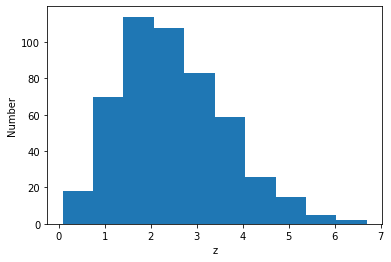

In [4]:
z = np.random.beta(3, 9, Nobs)*10
plt.hist(z)
plt.xlabel('z')
plt.ylabel('Number')

Source frame chirp mass follows galactic neutron star population,

$$
M_c \sim N(1.17 M_{\odot}, 0.1M_{\odot})
$$

Text(0, 0.5, 'Number')

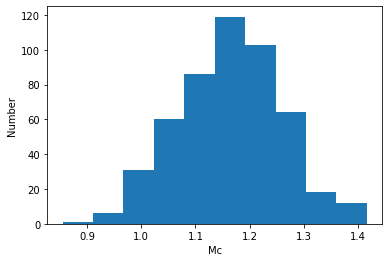

In [5]:
Mc = np.random.normal(1.17, 0.1, Nobs) # in solar mass unit
plt.hist(Mc)
plt.xlabel('Mc')
plt.ylabel('Number')

Detector frame chirp mass,
$$
Mcz = Mc(1+z)
$$

Text(0, 0.5, 'Number')

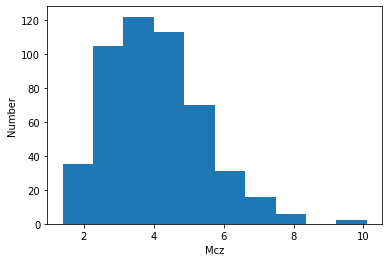

In [6]:
Mcz = Mc*(1+z)
plt.hist(Mcz)
plt.xlabel('Mcz')
plt.ylabel('Number')

Cosmology is assumed to be Planck18. $\sigma_{DL}/DL$ is inversely proportional to snr, reaching 30% of snr at z=10. Also place a lower cut $\sigma_{DL}/DL$ is 0.1 to avoid unphysical scenario of $\sigma_{DL} \rightarrow 0$ at low $z$.

$$
\frac{\sigma_{DL}}{DL} = 0.1 + 0.3 \frac{DL}{DL(z=10)}
$$

Text(0, 0.5, 'Number')

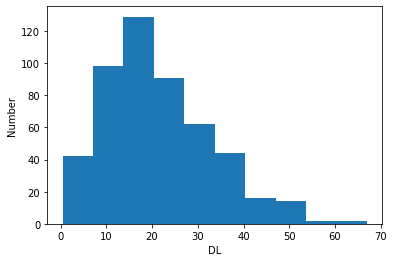

In [7]:
cp = cosmo.Planck18
DL = cp.luminosity_distance(z).to(u.Gpc).value
plt.hist(DL)
plt.xlabel('DL')
plt.ylabel('Number')

In [8]:
DL10 = cp.luminosity_distance(10).to(u.Gpc).value
sigma_DL = DL*(0.1+0.3*(DL/DL10))

$$
zo = z, do = DL+\sigma_{DL}*randn(Nobs)
$$

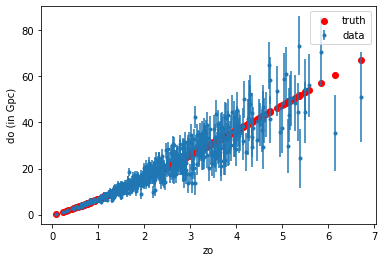

In [9]:
zo = z
do = DL+sigma_DL*np.random.randn(Nobs) # in Gpc
plt.errorbar(zo, do, yerr=sigma_DL, fmt='.', label='data')
plt.scatter(zo, cp.luminosity_distance(zo).to(u.Gpc).value, color='red', label='truth')
plt.xlabel('zo')
plt.ylabel('do (in Gpc)')
plt.legend()

# Pop Cosmo Estimation

Let's plot the residue.

Text(0, 0.5, 'residue')

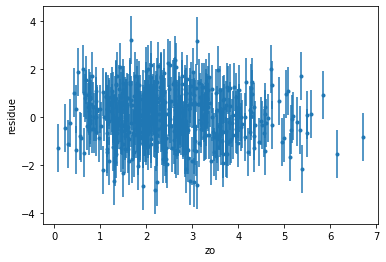

In [10]:
plt.errorbar(zo, (do-cp.luminosity_distance(zo).to(u.Gpc).value)/sigma_DL, yerr=np.ones(Nobs), fmt='.')
plt.xlabel('zo')
plt.ylabel('residue')

# Toy Model I

Here $\vec{\Omega}_P = \{\mu_P \}$, and $\vec{\Omega}_C = \{H_0\}$, we know $\sigma_P$ with infinite precision.

Under simplified asuumptions:
1. no covariance between $M_{cz}^{obs}$ and $D_L^{obs}$,
2. $\sigma_{M_{cz}^{obs}} = 0$

$M_{cz}$ integral becomes analytic.

Posterior of $\{H_0, \mu_P\}$ is,

$$
P(H_0, \mu_P| \bigcap_i D_i) \propto P(H_0).P(\mu_P).\prod_i \int_{D_L} N_{D_L}(D_L^{obs, i}, \sigma_{D_L}^{obs, i}).P(D_L).\Big(\frac{1}{1+z(D_L, H_0)}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z(D_L, H_0)}\Big )}(\mu_P, \sigma_P^{\text{true}}).dD_L
$$

$$
\frac{d ln P(H_0| \bigcap_i D_i)}{dH_0} \propto \sum_{i=1}^{\infty} \frac{D_L^{obs, i}}{(1+D_L^{obs, i}.H_0)}\Big [-1 + \Big(\Big((M_c^i)^2-\mu_P^{true}.M_c^i\Big )/(\sigma_P^{\text{true}})^2\Big ) \Big ]
$$

Here we will investigate whether Posterior is more informative than Prior or not.  

Pymc does not have interpolation module, so it is written.

In [11]:
def at_interp(x, xs, ys):
    x = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    ind = ate.searchsorted(xs, x)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1])
    return r*ys[ind] + (1-r)*ys[ind-1]

Routine for Luminosity Distance

In [12]:
def Ez(z, Om, w, wDM):
    opz = 1 + z
    return at.sqrt(Om*opz**(3*(1+wDM)) + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w, wDM):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w, wDM)
    I = 0.5*dz*(fz[:-1] + fz[1:])
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

Cosmological Parameter Estimation by Pymc

A note on the maths:
$$
P(H_0, \mu_P| \bigcap_i D_i) \propto P(H_0).P(\mu_P).\prod_i \int_{D_L} N_{D_L}(D_L^{obs, i}, \sigma_{D_L}^{obs, i}).P(D_L).\Big(\frac{1}{1+z(D_L, H_0)}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z(D_L, H_0)}\Big )}(\mu_P, \sigma_P^{\text{true}}).dD_L
$$

as $P(D_L)=P(z).\frac{dz}{dD_L}$,

$$
P(H_0, \mu_P| \bigcap_i D_i) \propto P(H_0).P(\mu_P).\prod_i \int_{z} N_{D_L(z, H_0)}(D_L^{obs, i}, \sigma_{D_L}^{obs, i}).P(z).\Big(\frac{1}{1+z}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z}\Big )}(\mu_P, \sigma_P^{\text{true}}).dz
$$

or,

$$
P(H_0, \mu_P| \bigcap_i D_i) \propto \prod_i \left\langle \int_{z} N_{D_L(z, H_0)}(D_L^{obs, i}, \sigma_{D_L}^{obs, i}).P(z).\Big(\frac{1}{1+z}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z}\Big )}(\mu_P, \sigma_P^{\text{true}}).dz \right\rangle _{H_0, ~\mu_P ~samples}
$$

or,

$$
P(H_0, \mu_P| \bigcap_i D_i) \propto \prod_i \left\langle N_{D_L(z, H_0)}(D_L^{obs, i}, \sigma_{D_L}^{obs, i}).P(z).\Big(\frac{1}{1+z}\Big ).N_{\Big( \frac{M_{cz}^{obs, i}}{1+z}\Big )}(\mu_P, \sigma_P^{\text{true}}) \right\rangle _{H_0, ~\mu_P, ~z ~samples}
$$

In [13]:
sigma_P = 0.1

Om = cp.Om0
w = -1
wDM = 0

In [14]:
def make_model(Mcz, do, sigma_DL, priors, zmax=100, Nz=1024):
    
    Mcz = np.atleast_1d(Mcz)
    Nobs = Mcz.shape[0]

    zinterp = np.expm1(np.linspace(np.log(1), np.log1p(zmax), Nz))

    with pm.Model() as model:
        #priors = np.array([mu_P_central, mu_P_dispersion, h_central, h_dispersion])
        
        mu_P = pm.Uniform('mu_P', priors[0]-priors[1], priors[0]+priors[1]) # in solar mass unit

        h = pm.Uniform('h', priors[2]-priors[3], priors[2]+priors[3])
        
        dH = pm.Deterministic('dH', 2.99792 / h) # Gpc
        
        z_unit = pm.Beta('z_unit', 3, 9, shape=Nobs)
        z = pm.Deterministic('z', z_unit*10)
        
        Mc = pm.Deterministic('Mc', Mcz/(1 + z))
        pm.Potential('mcprior', at.sum(pm.logp(pm.Normal.dist(mu_P, sigma_P), Mc))) #why are we always taking logs?
        pm.Potential('mcjac', at.sum(-at.log1p(z))) # Comes from integrating over delta-function likelihood for mc

        dCinterp = dH*dCs(zinterp, Om, w, wDM)
        dLinterp = dLs(zinterp, dCinterp)

        dL = pm.Deterministic('dL', at_interp(z, zinterp, dLinterp))

        pm.Normal('dL_likelihood', mu=dL, sigma=sigma_DL, observed=do)
    return model

In [15]:
Nrun = 20
prior_sd_mu_P = np.linspace(0.01, 0.2, Nrun)
pos_sd_mu_P = np.zeros(Nrun)

for i in range(Nrun):
    priors = np.array([1.2, prior_sd_mu_P[i], 0.7, 0.5]) #priors = np.array([mu_P_central, mu_P_dispersion, h_central, h_dispersion])
    
    with make_model(Mcz, do, sigma_DL, priors) as model:
        trace = pm.sample()
    
    with model:
        summary = az.summary(trace, var_names=['mu_P', 'h'])
    
    print('mu_P_mean=', summary['mean'][0], 'mu_P_sd=', summary['sd'][0], 'h_mean=', summary['mean'][1], 'h_sd=', summary['sd'][1])
    
    pos_sd_mu_P[i] = summary['sd'][0]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


mu_P_mean= 1.197 mu_P_sd= 0.005 h_mean= 0.662 h_sd= 0.008


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


mu_P_mean= 1.191 mu_P_sd= 0.008 h_mean= 0.669 h_sd= 0.011


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


mu_P_mean= 1.186 mu_P_sd= 0.011 h_mean= 0.674 h_sd= 0.013


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.


mu_P_mean= 1.181 mu_P_sd= 0.012 h_mean= 0.679 h_sd= 0.014


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
The acceptance probability does not match the target. It is 0.6949, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.18 mu_P_sd= 0.015 h_mean= 0.68 h_sd= 0.017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.178 mu_P_sd= 0.016 h_mean= 0.682 h_sd= 0.017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.177 mu_P_sd= 0.016 h_mean= 0.684 h_sd= 0.018


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.177 mu_P_sd= 0.016 h_mean= 0.683 h_sd= 0.018


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


mu_P_mean= 1.176 mu_P_sd= 0.016 h_mean= 0.684 h_sd= 0.017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.176 mu_P_sd= 0.016 h_mean= 0.684 h_sd= 0.018


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.177 mu_P_sd= 0.016 h_mean= 0.683 h_sd= 0.018


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.177 mu_P_sd= 0.016 h_mean= 0.684 h_sd= 0.017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.177 mu_P_sd= 0.016 h_mean= 0.683 h_sd= 0.017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


mu_P_mean= 1.177 mu_P_sd= 0.016 h_mean= 0.684 h_sd= 0.017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.176 mu_P_sd= 0.016 h_mean= 0.685 h_sd= 0.018


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.


mu_P_mean= 1.177 mu_P_sd= 0.015 h_mean= 0.683 h_sd= 0.017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


mu_P_mean= 1.177 mu_P_sd= 0.016 h_mean= 0.683 h_sd= 0.017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.177 mu_P_sd= 0.015 h_mean= 0.683 h_sd= 0.017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


mu_P_mean= 1.177 mu_P_sd= 0.016 h_mean= 0.684 h_sd= 0.017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.


mu_P_mean= 1.175 mu_P_sd= 0.016 h_mean= 0.685 h_sd= 0.017


In [16]:
Nrun = 20
prior_sd_h = np.linspace(0.001, 0.1, Nrun)
pos_sd_h = np.zeros(Nrun)

for i in range(Nrun):
    priors = np.array([1.2, 0.5, 0.7, prior_sd_h[i]]) #priors = np.array([mu_P_central, mu_P_dispersion, h_central, h_dispersion])
    
    with make_model(Mcz, do, sigma_DL, priors) as model:
        trace = pm.sample()
    
    with model:
        summary = az.summary(trace, var_names=['mu_P', 'h'])
    
    print('mu_P_mean=', summary['mean'][0], 'mu_P_sd=', summary['sd'][0], 'h_mean=', summary['mean'][1], 'h_sd=', summary['sd'][1])
    
    pos_sd_h[i] = summary['sd'][1]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


mu_P_mean= 1.163 mu_P_sd= 0.006 h_mean= 0.7 h_sd= 0.001


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.


mu_P_mean= 1.164 mu_P_sd= 0.007 h_mean= 0.699 h_sd= 0.003


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.


mu_P_mean= 1.165 mu_P_sd= 0.008 h_mean= 0.698 h_sd= 0.006


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


mu_P_mean= 1.167 mu_P_sd= 0.009 h_mean= 0.695 h_sd= 0.008


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


mu_P_mean= 1.168 mu_P_sd= 0.011 h_mean= 0.694 h_sd= 0.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


mu_P_mean= 1.169 mu_P_sd= 0.012 h_mean= 0.692 h_sd= 0.013


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.


mu_P_mean= 1.172 mu_P_sd= 0.013 h_mean= 0.688 h_sd= 0.014


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
The acceptance probability does not match the target. It is 0.7168, but should be close to 0.8. Try to increase the number of tuning steps.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.173 mu_P_sd= 0.013 h_mean= 0.687 h_sd= 0.014


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.176 mu_P_sd= 0.014 h_mean= 0.685 h_sd= 0.016


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


mu_P_mean= 1.176 mu_P_sd= 0.014 h_mean= 0.684 h_sd= 0.016


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.176 mu_P_sd= 0.015 h_mean= 0.684 h_sd= 0.016


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.176 mu_P_sd= 0.016 h_mean= 0.684 h_sd= 0.017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
The acceptance probability does not match the target. It is 0.6794, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.177 mu_P_sd= 0.017 h_mean= 0.683 h_sd= 0.018


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


mu_P_mean= 1.178 mu_P_sd= 0.016 h_mean= 0.682 h_sd= 0.018


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.175 mu_P_sd= 0.016 h_mean= 0.685 h_sd= 0.018


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.175 mu_P_sd= 0.016 h_mean= 0.685 h_sd= 0.018


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.175 mu_P_sd= 0.015 h_mean= 0.685 h_sd= 0.017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


mu_P_mean= 1.175 mu_P_sd= 0.016 h_mean= 0.685 h_sd= 0.017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.177 mu_P_sd= 0.016 h_mean= 0.683 h_sd= 0.017


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Souroy\Anaconda3\envs\PymcCosmography\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, h, z_unit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_P_mean= 1.176 mu_P_sd= 0.015 h_mean= 0.684 h_sd= 0.017


In [17]:
with h5py.File("prior_pos_500.h5", "w") as file:
    file.create_dataset('prior_sd_mu_P', data=prior_sd_mu_P)
    file.create_dataset('pos_sd_mu_P', data=pos_sd_mu_P)
    file.create_dataset('prior_sd_h', data=prior_sd_h)
    file.create_dataset('pos_sd_h', data=pos_sd_h)
file.close()